In [1]:
# Configure environment
from os import path
CURR_PATH = path.abspath("__file__") # Full path to current script
ROOT_PATH = path.dirname(path.dirname(path.dirname(CURR_PATH)))
import sys; sys.path.insert(0, ROOT_PATH)

# Models to predict return rates and outliers
This notebook walks through our models applied to a toy example dataset. These models predict future return rates and classify products likely to have outlier return rates in the future. It also walks through some of our analyses on whether NLP signals really add value.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.models import NN_Regressor, RF_Regressor, RF_Classifier
from src.models.metrics import asymmetric_mse, bootstrap

from src.features import Sentiment

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/alex/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
# Load data
products_df = pd.read_csv(path.join(ROOT_PATH, "demo", "data", "toydata_products.csv"))
reviews_df = pd.read_csv(path.join(ROOT_PATH, "demo", "data", "toydata_reviews.csv"))

products_df.head()

,wfsku,mkcname,avgweight,returnratescaled,year
0,A,Bath,29.071028,0.443155,2017
1,B,Bath,32.733974,0.326510,2017
2,C,Bedroom,26.795903,0.703419,2017
3,D,Bedroom,37.564827,0.013095,2017
4,E,Lighting,29.051481,0.050202,2017


In [4]:
# one-hot encode market category name variable
for mkcname in products_df['mkcname'].unique():
    products_df[f'is_mkcname_{mkcname}'] = (products_df['mkcname'] == mkcname).astype(int)

## *Extract NLP Sentiment Features*

In [5]:
# Extract NLP Sentiment Features
sentiment = Sentiment()
sentiment_features = sentiment.extract(reviews_df['rvprcomments'])
reviews_df = pd.concat([reviews_df, sentiment_features], axis=1)

# Get NLP feature columns
nlp_feature_cols = list(sentiment_features.columns)

In [6]:
# Aggregate up to product level
nlp_features_product_level = reviews_df.groupby(['wfsku', 'year'])[nlp_feature_cols].mean()

# Merge NLP features into product-level data
products_df_full = products_df.merge(nlp_features_product_level, on=['wfsku', 'year'], how='left')

# View data
products_df_full.sort_values(['wfsku', 'year']).head()

,wfsku,mkcname,avgweight,returnratescaled,year,is_mkcname_Bath,is_mkcname_Bedroom,is_mkcname_Lighting,subjectivity,neg,neu,pos,compound
0,A,Bath,29.071028,0.443155,2017,1,0,0,0.601183,0.039611,0.660944,0.299463,0.486083
10,A,Bath,28.867765,0.436672,2018,1,0,0,0.605222,0.030174,0.678739,0.291130,0.412261
20,A,Bath,29.267241,0.408752,2019,1,0,0,NaN,NaN,NaN,NaN,NaN
1,B,Bath,32.733974,0.326510,2017,1,0,0,0.672526,0.044696,0.585321,0.369964,0.423425
11,B,Bath,32.291611,0.431587,2018,1,0,0,0.670257,0.040455,0.615205,0.344341,0.468632


# Regression: Predicting future return rates

In the training data, we use 2017 product data to predict 2018 return rates. For test data, use 2018 product data to predict 2019 return rates.

In [7]:
prods_17 = products_df_full[products_df_full['year']==2017].reset_index(drop=True)
prods_18 = products_df_full[products_df_full['year']==2018].reset_index(drop=True)
prods_19 = products_df_full[products_df_full['year']==2019].reset_index(drop=True)

X_train = prods_17.drop(['wfsku', 'year', 'mkcname'], axis=1)
X_train_non_nlp = X_train.drop(nlp_feature_cols, axis=1)
y_train = prods_18['returnratescaled']

X_test = prods_18.drop(['wfsku', 'year', 'mkcname'], axis=1)
X_test_non_nlp = X_test.drop(nlp_feature_cols, axis=1)
y_test = prods_19['returnratescaled']

## *Random Forest Regressor*

In [8]:
# Set up Random Forest Regressor arguments
rf_kwargs = dict(
    n_estimators=100,
    max_depth=4,
    min_samples_leaf=3,
    random_state=10 )
model_full = RF_Regressor(**rf_kwargs)
model_non_nlp = RF_Regressor(**rf_kwargs)

In [9]:
# Train full (includes NLP signals) model
model_full.train(X_train, y_train)
y_pred_full = model_full.predict(X_test)
full_score = np.round(np.sqrt(np.mean(asymmetric_mse(y_pred_full, y_test))), 4)
print("-RF Test Scores-")
print(f"Full:\t{full_score}")

# Train non-NLP model
model_non_nlp.train(X_train_non_nlp, y_train)
y_pred_non_nlp = model_non_nlp.predict(X_test_non_nlp)
non_nlp_score = np.round(np.sqrt(np.mean(asymmetric_mse(y_pred_non_nlp, y_test))), 4)
print(f"NonNLP:\t{non_nlp_score}")

-RF Test Scores-
Full:	0.0335
NonNLP:	0.0352


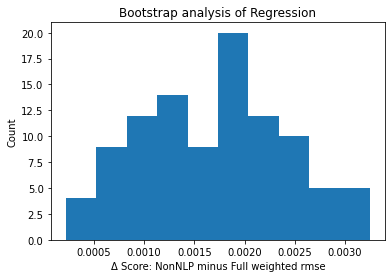

In [10]:
# Resample X_test to ensure the different in score is meaningful
# Basically ensures we haven't fit to the test set
score = lambda true, pred: np.sqrt(np.mean(asymmetric_mse(true, pred)))

full_scores, non_nlp_scores = bootstrap(
    full_model=model_full, 
    non_nlp_model=model_non_nlp, 
    X_full=X_test, 
    y=y_test, 
    score_func=score, 
    nlp_cols=nlp_feature_cols
)

plt.hist(non_nlp_scores - full_scores)
plt.title('Bootstrap analysis of Regression')
plt.xlabel('Δ Score: NonNLP minus Full weighted rmse')
plt.ylabel('Count')
plt.show()

The NonNLP model consistently has a higher score (worse performance) than the full model, even with different samples of the test set. Thus, we are more confident that the difference between full model has meaningfully better performance.

## *Neural Network Regressor*

Note that the performance of the Neural network doesn't look great on this toy dataset because it's so small.

In [11]:
# Set up Full and Non-NLP NNs
nn_full = NN_Regressor()
nn_non_nlp = NN_Regressor()

# Train models and save predictions
nn_full.train(X_train, y_train)
y_pred_nn_full = nn_full.predict(X_test).ravel()

nn_non_nlp.train(X_train_non_nlp, y_train)
y_pred_nn_non_nlp = nn_non_nlp.predict(X_test_non_nlp).ravel()

Start training model
Succesfully trained model, time used 1.589599370956421
Start training model
Succesfully trained model, time used 0.8240208625793457


In [12]:
full_score_nn = score(y_test, y_pred_nn_full)
non_nlp_score_nn = score(y_test, y_pred_nn_non_nlp)
print("-NN Test Scores-")
print(f"Full:\t{np.round(full_score_nn, 4)}")
print(f"NonNLP:\t{np.round(non_nlp_score_nn, 4)}")

-NN Test Scores-
Full:	0.2334
NonNLP:	0.305


# Classification: Predicting future outliers

We convert this problem into a classification problem. Instead of predicting the raw return rate, we use 2017 product data to predict which products will have outlier return rates in 2018. Again, our test set is 2018 product data predicting 2019 return rate outliers.

We use a threshold rule to determine whether a product is an outlier. Within each market category, the largest $N$\% return rates are classified as outliers, while the rest are normal. These are calculated separately for each year in the data.

We choose precision scores based on the business context: we'd like to avoid false positives and ensure that a positive classification is really indicative of an outlier.

In [13]:
from sklearn.metrics import precision_score

## *Regression + Rank*

This method consists of using the regression's predicted values and ranking them to determine outliers. 

In [14]:
# Get ground truth classifications from RF_Regressor class
threshold=0.4  # high threshold because this dataset is so small

y_test_cla = model_full._rates_to_outlier_bool(
    rates=prods_19['returnratescaled'],
    mkcnames=prods_19['mkcname'],
    threshold=threshold
)

y_train_cla = model_full._rates_to_outlier_bool(
    rates=prods_18['returnratescaled'],
    mkcnames=prods_18['mkcname'],
    threshold=threshold
)

In [15]:
# Rank the predicted rates (already fitted in the RF Regressor section)
mkcnames = prods_18['mkcname']
y_pred_full_cla = model_full.predict_outliers(X_test, mkcnames, threshold=threshold)
y_pred_nonnlp_cla = model_non_nlp.predict_outliers(X_test_non_nlp, mkcnames, threshold=threshold)

In [16]:
# Get precision scores for models
full_prec = precision_score(y_test_cla, y_pred_full_cla)
non_nlp_prec = precision_score(y_test_cla, y_pred_nonnlp_cla)

print("-Reg+Rank Test Scores-")
print(f"Full:\t{np.round(full_prec, 4)}")
print(f"NonNLP:\t{np.round(non_nlp_prec, 4)}")

-Reg+Rank Test Scores-
Full:	0.75
NonNLP:	0.75


## *Random Forest Classifier*
Here, we directly train a random forest classifier to classify outliers without predicting the raw return rate.

In [17]:
# Set up Full and Non-NLP Classifiers
full_rfcla = RF_Classifier(**rf_kwargs)
nonnlp_rfcla = RF_Classifier(**rf_kwargs)

# Train models and save predictions
full_rfcla.train(X_train, y_train_cla)
y_pred_rfcla_full = full_rfcla.predict(X_test)

nonnlp_rfcla.train(X_train_non_nlp, y_train_cla)
y_pred_rfcla_non_nlp = nonnlp_rfcla.predict(X_test_non_nlp)

In [18]:
# Get precision scores for models
full_prec_rfcla = precision_score(y_test_cla, y_pred_rfcla_full)
non_nlp_prec_rfcla = precision_score(y_test_cla, y_pred_rfcla_non_nlp)

print("-Reg+Rank Test Scores-")
print(f"Full:\t{np.round(full_prec_rfcla, 4)}")
print(f"NonNLP:\t{np.round(non_nlp_prec_rfcla, 4)}")

-Reg+Rank Test Scores-
Full:	0.75
NonNLP:	0.0


/Users/alex/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The warning above is expected because the random forest classifier predicts no positive classes: all are predicted to be 0. The precision metric is not well-defined for zero positive classes predicted (since the denominator is 0), which is why we see this warning.